## Necessary libraries

In [1]:
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt

# Adjust to whichever file you're trying to analyze, then hit run until the end, and adjust cutoff distance for the distance clusters should be from one another

In [2]:
cutoff = 2.5
start_file = "100_20mer10f_0.0003dt_start.txt"
traj_file = "100_20mer10f_0.0003dt.gsd"
with open(start_file) as f:
    lines = f.read().strip().splitlines()

start_frame     = int(lines[0])
beads_per_flake = int(lines[1])
sim_time = float(lines[2])

In [3]:
print(sim_time, "seconds")

5982.745808601379 seconds


In [4]:
def compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake):
    Lx, Ly, Lz = box_lengths

    n_beads = len(flake_positions)
    if n_beads == 0:
        return np.zeros((0, 3))

    assert n_beads % beads_per_flake == 0, (
        f"len(flake_positions)={n_beads} is not divisible by "
        f"beads_per_flake={beads_per_flake}"
    )

    n_flakes = n_beads // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        flake = flake_positions[i * beads_per_flake : (i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # minimum image
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        com = np.mean(unwrapped, axis=0)

        # wrap COM into [-L/2, L/2]
        com[0] = (com[0] + Lx/2) % Lx - Lx/2
        com[1] = (com[1] + Ly/2) % Ly - Ly/2
        com[2] = (com[2] + Lz/2) % Lz - Lz/2

        flake_coms.append(com)

    return np.array(flake_coms)

In [5]:
def count_clusters(flake_coms, box_lengths, cutoff, include_singletons=True):
    Lx, Ly, Lz = box_lengths
    n = len(flake_coms)
    adjacency = [set() for _ in range(n)]

    for i in range(n):
        for j in range(i + 1, n):
            dr = flake_coms[j] - flake_coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            if np.linalg.norm(dr) < cutoff:
                adjacency[i].add(j)
                adjacency[j].add(i)

    visited = set()
    clusters = []

    for i in range(n):
        if i not in visited:
            cluster = []
            stack = [i]
            while stack:
                cur = stack.pop()
                if cur not in visited:
                    visited.add(cur)
                    cluster.append(cur)
                    stack.extend(adjacency[cur] - visited)

            if include_singletons or len(cluster) > 1:
                clusters.append(cluster)

    return len(clusters), [len(c) for c in clusters], clusters

In [6]:
def analyze_clusters_over_time(traj, start=start_frame, step=1, cutoff=cutoff, beads_per_flake=beads_per_flake):
    times = []
    n_clusters_list = []
    avg_cluster_sizes = []

    for frame_idx in range(start, len(traj), step):
        frame = traj[frame_idx]
        box_lengths = frame.configuration.box[:3]

        flake_type = "F"
        flake_typeid = frame.particles.types.index(flake_type)
        positions = frame.particles.position
        typeids = frame.particles.typeid
        flake_positions = positions[typeids == flake_typeid]

        flake_coms = compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake)
        n_clusters, sizes, _ = count_clusters(flake_coms, box_lengths, cutoff)

        times.append(frame_idx)
        n_clusters_list.append(n_clusters)
        avg_cluster_sizes.append(np.mean(sizes) if sizes else 0)

    return times, n_clusters_list, avg_cluster_sizes

In [7]:
traj = gsd.hoomd.open(traj_file)
times, n_clusters, avg_sizes = analyze_clusters_over_time(
    traj,
    start=start_frame,   # post-shrink
    step=1, # analyze every "x" frame, leave this at 1
    cutoff=cutoff
) # this function is used to initially calculate the decorrelation time, so that we know every how many certain amount of frames to analyze. 

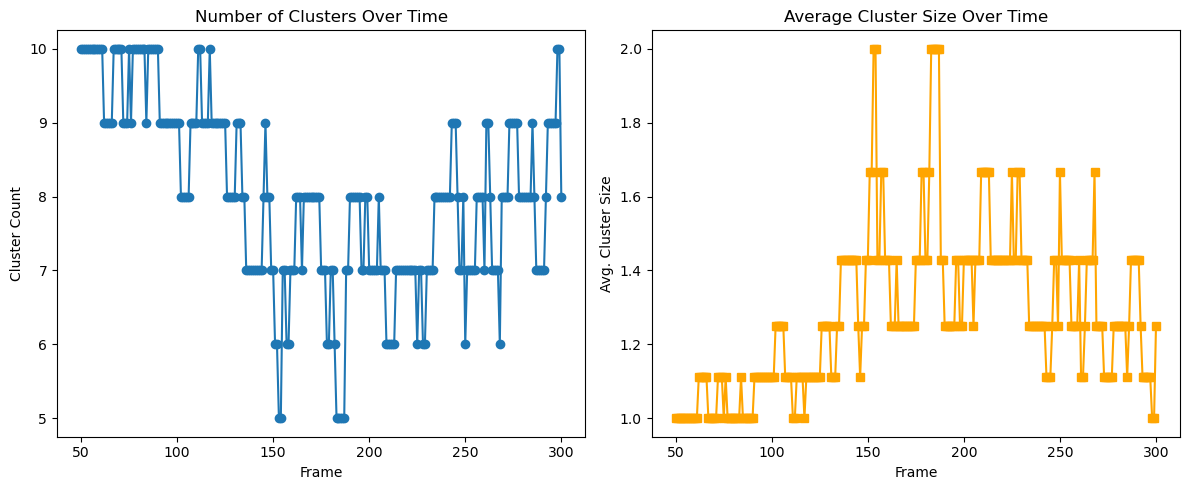

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(times, n_clusters, marker='o')
plt.title("Number of Clusters Over Time")
plt.xlabel("Frame")
plt.ylabel("Cluster Count")

plt.subplot(1, 2, 2)
plt.plot(times, avg_sizes, marker='s', color='orange')
plt.title("Average Cluster Size Over Time")
plt.xlabel("Frame")
plt.ylabel("Avg. Cluster Size")

plt.tight_layout()
plt.show()

In [9]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))  
    acorr = np.fft.irfft(ft * np.conjugate(ft))  
    acorr /= (len(array) * np.var(array))        

    dt = np.where(acorr < 0)[0][0]               
    nsamples = len(array) // dt                  

    acorr = acorr[dt:nsamples]                  

    return nsamples, dt
n, dt = autocorr1D(avg_sizes)

# Decorrelation time is now calculated; now we can plot all the independent samples present within this simulation. Lower independent samples means more average aggregation over time is occurring, should occur as kT is increased. 

In [10]:
print("Independent samples and decorrelation time:", n, dt)

Independent samples and decorrelation time: 4 60


In [11]:
# now we can plot every "dt"th frame, whose length should be ~= independent samples
decorrelated_times = times[::dt]
decorrelated_sizes = avg_sizes[::dt]
decorrelated_clusters = n_clusters[::dt]

In [12]:
sd_times = np.std(decorrelated_times)
sd_sizes = np.std(decorrelated_sizes)
sd_clusters = np.std(decorrelated_clusters)

In [13]:
print(sd_times, sd_sizes, sd_clusters)

84.8528137423857 0.17050751980751333 1.16619037896906


In [14]:
print(len(decorrelated_sizes)) # verifying it is equal to calculated independent samples

5


Text(0, 0.5, 'Avg Cluster Size')

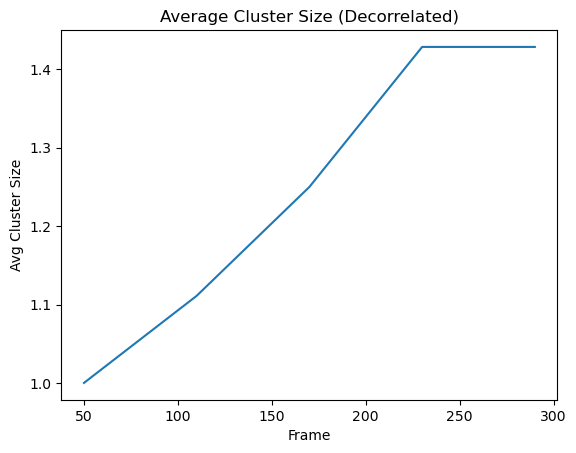

In [15]:
plt.plot(decorrelated_times, decorrelated_sizes) # plot of every independent sample in simulation
plt.title("Average Cluster Size (Decorrelated)")
plt.xlabel("Frame")
plt.ylabel("Avg Cluster Size")

In [16]:
np.mean(decorrelated_sizes)

1.2436507936507937

In [17]:
np.mean(decorrelated_clusters)

8.2

Text(0, 0.5, '# Clusters')

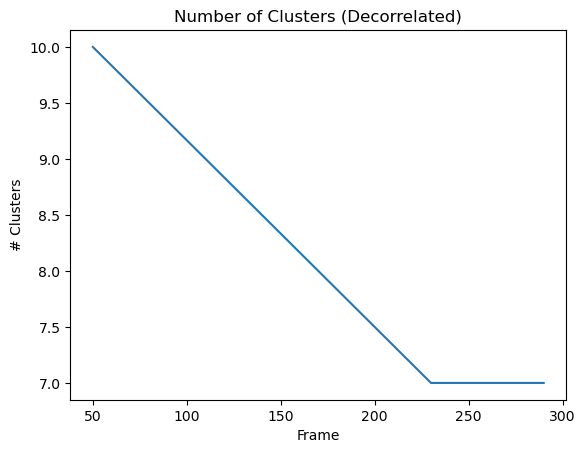

In [18]:
plt.plot(decorrelated_times, decorrelated_clusters)
plt.title("Number of Clusters (Decorrelated)")
plt.xlabel("Frame")
plt.ylabel("# Clusters")